In [21]:
# Initial Imports
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [22]:
# Read in CSV, DF created to Organize data to Subject Descriptor, which then located the correct Inflation Descriptors
df = pd.read_csv(
    Path("WEOApril2021all.csv")
)

df = df[(df["Subject Descriptor"]=="Inflation, average consumer prices") & (df["Units"]=="Percent change")]
df.drop(columns=["Subject Descriptor", "Units", "Scale", "Estimates Start After"], inplace=True)
df = df.T
df.columns = df.loc["Country"]
df = df.drop("Country", axis=0)
df

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
WEO Country Code,512,914,612,614,311,213,911,314,193,122,...,111,298,927,846,299,582,487,474,754,698
ISO,AFG,ALB,DZA,AGO,ATG,ARG,ARM,ABW,AUS,AUT,...,USA,URY,UZB,VUT,VEN,VNM,WBG,YEM,ZMB,ZWE
WEO Subject Code,PCPIPCH,PCPIPCH,PCPIPCH,PCPIPCH,PCPIPCH,PCPIPCH,PCPIPCH,PCPIPCH,PCPIPCH,PCPIPCH,...,PCPIPCH,PCPIPCH,PCPIPCH,PCPIPCH,PCPIPCH,PCPIPCH,PCPIPCH,PCPIPCH,PCPIPCH,PCPIPCH
Subject Notes,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...,Annual percentages of average consumer prices ...
Country/Series-specific Notes,"See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...",...,"See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr...","See notes for: Inflation, average consumer pr..."
1980,NaN,NaN,9.668,46.708,18.999,NaN,NaN,NaN,10.136,6.325,...,13.502,63.475,NaN,11.24,21.355,25.156,NaN,NaN,11.729,NaN
1981,NaN,NaN,14.61,1.391,11.465,NaN,NaN,NaN,9.488,6.807,...,10.378,34.046,NaN,26.846,16.244,69.6,NaN,NaN,13.997,5.556
1982,NaN,NaN,6.593,1.833,4.17,NaN,NaN,NaN,11.352,5.44,...,6.158,18.991,NaN,6.673,9.607,95.401,NaN,NaN,12.495,0.59
1983,NaN,NaN,7.835,1.833,2.346,NaN,NaN,NaN,10.039,3.335,...,3.16,49.198,NaN,1.653,6.242,49.487,NaN,NaN,19.692,-8.452
1984,NaN,NaN,6.31,1.833,3.844,NaN,NaN,NaN,3.96,5.665,...,4.368,55.305,NaN,5.516,12.25,64.897,NaN,NaN,20.019,-1.857


In [23]:
#Created DataFrame for the US, Created Columns for the model
China_df = df[['China']]

China_Inflation = China_df.drop(labels=["WEO Country Code", "ISO", "WEO Subject Code", "Subject Notes", "Country/Series-specific Notes"], axis=0)

China_Inflation.rename(columns = {'Country':'Year'}, inplace = True)

China_Inflation = China_Inflation.replace(",","", regex=True)
China_Inflation = China_Inflation.astype("float")



In [30]:
def window_data(China_Inflation, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(China_Inflation) - window):
        features = China_Inflation.iloc[i : (i + window), feature_col_number]
        target = China_Inflation.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [31]:
China_Inflation.dtypes

Country
China    float64
dtype: object

In [33]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 20

feature_column = 0
target_column = 0
X, y = window_data(China_Inflation, window_size, feature_column, target_column)
print (f"X sample values:\n{X} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[ 1.8    2.5    2.     2.     2.7    9.3    6.5    7.3   18.8   18.
   3.1    3.4    6.4   14.7   24.1   17.1    8.3    2.8   -0.8   -1.4  ]
 [ 2.5    2.     2.     2.7    9.3    6.5    7.3   18.8   18.     3.1
   3.4    6.4   14.7   24.1   17.1    8.3    2.8   -0.8   -1.4    0.4  ]
 [ 2.     2.     2.7    9.3    6.5    7.3   18.8   18.     3.1    3.4
   6.4   14.7   24.1   17.1    8.3    2.8   -0.8   -1.4    0.4    0.7  ]
 [ 2.     2.7    9.3    6.5    7.3   18.8   18.     3.1    3.4    6.4
  14.7   24.1   17.1    8.3    2.8   -0.8   -1.4    0.4    0.7   -0.8  ]
 [ 2.7    9.3    6.5    7.3   18.8   18.     3.1    3.4    6.4   14.7
  24.1   17.1    8.3    2.8   -0.8   -1.4    0.4    0.7   -0.8    1.2  ]
 [ 9.3    6.5    7.3   18.8   18.     3.1    3.4    6.4   14.7   24.1
  17.1    8.3    2.8   -0.8   -1.4    0.4    0.7   -0.8    1.2    3.9  ]
 [ 6.5    7.3   18.8   18.     3.1    3.4    6.4   14.7   24.1   17.1
   8.3    2.8   -0.8   -1.4    0.4    0.7   -0.8    1.2 

In [34]:
type(X)



#XS = float(X)
#yS = float(y)

numpy.ndarray

In [35]:
# Use 90% of the data for training and the remainder for testing
split = int(0.9 * len(X))
X_train = X[: split]
X_test = X[split - 10:]
y_train = y[: split]
y_test = y[split - 10:]

In [36]:

# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [37]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.1254902 ]
  [0.15294118]
  [0.13333333]
  [0.13333333]
  [0.16078431]
  [0.41960784]
  [0.30980392]
  [0.34117647]
  [0.79215686]
  [0.76078431]
  [0.17647059]
  [0.18823529]
  [0.30588235]
  [0.63137255]
  [1.        ]
  [1.        ]
  [1.        ]
  [0.57534247]
  [0.08219178]
  [0.        ]]

 [[0.15294118]
  [0.13333333]
  [0.13333333]
  [0.16078431]
  [0.41960784]
  [0.30980392]
  [0.34117647]
  [0.79215686]
  [0.76078431]
  [0.17647059]
  [0.18823529]
  [0.30588235]
  [0.63137255]
  [1.        ]
  [0.7254902 ]
  [0.52432432]
  [0.43298969]
  [0.08219178]
  [0.        ]
  [0.24657534]]

 [[0.13333333]
  [0.13333333]
  [0.16078431]
  [0.41960784]
  [0.30980392]
  [0.34117647]
  [0.79215686]
  [0.76078431]
  [0.17647059]
  [0.18823529]
  [0.30588235]
  [0.63137255]
  [1.        ]
  [0.7254902 ]
  [0.38039216]
  [0.22702703]
  [0.06185567]
  [0.        ]
  [0.24657534]
  [0.28767123]]

 [[0.13333333]
  [0.16078431]
  [0.41960784]
  [0.30980392]
  [0.341176

In [39]:

# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [40]:

# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.4

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))


model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer


model.add(Dense(1))

In [41]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error", metrics= ["accuracy"])

In [42]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 5)             140       
_________________________________________________________________
dropout (Dropout)            (None, 20, 5)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 5)             220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 5)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [43]:
# Train the model
model.fit(X_train, y_train, epochs=200, shuffle=False, batch_size=10, verbose=1)

Epoch 1/200
3/3 [==============================] - 3s 12ms/step - loss: 0.3347 - accuracy: 0.0417
Epoch 2/200
3/3 [==============================] - 0s 10ms/step - loss: 0.2839 - accuracy: 0.0417
Epoch 3/200
3/3 [==============================] - 0s 9ms/step - loss: 0.2491 - accuracy: 0.0417
Epoch 4/200
3/3 [==============================] - 0s 9ms/step - loss: 0.2428 - accuracy: 0.0417
Epoch 5/200
3/3 [==============================] - 0s 10ms/step - loss: 0.2158 - accuracy: 0.0417
Epoch 6/200
3/3 [==============================] - 0s 10ms/step - loss: 0.1955 - accuracy: 0.0417
Epoch 7/200
3/3 [==============================] - 0s 10ms/step - loss: 0.1799 - accuracy: 0.0417
Epoch 8/200
3/3 [==============================] - 0s 10ms/step - loss: 0.1694 - accuracy: 0.0417
Epoch 9/200
3/3 [==============================] - 0s 10ms/step - loss: 0.1621 - accuracy: 0.0417
Epoch 10/200
3/3 [==============================] - 0s 10ms/step - loss: 0.1412 - accuracy: 0.0417
Epoch 11/200
3/3 [===

In [44]:
# Evaluate the model
model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 621ms/step - loss: 0.0041 - accuracy: 0.0000e+00


[0.004093088675290346, 0.0]

In [45]:
predicted = model.predict(X_test)
predicted

array([[0.4468899 ],
       [0.40298483],
       [0.3856392 ],
       [0.3815447 ],
       [0.38551092],
       [0.3937902 ],
       [0.4008281 ],
       [0.40447977],
       [0.40872896],
       [0.41891912],
       [0.42874497],
       [0.43096024],
       [0.43238914]], dtype=float32)

In [47]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [48]:
# Create a DataFrame of Real and Predicted values
Inflation = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
Inflation

,Real,Predicted
2014,1.988,2.194162
2015,1.441,1.899998
2016,2.003,1.783783
2017,1.558,1.756350
2018,2.105,1.782923
2019,2.903,1.838394
2020,2.390,1.885548
2021,1.188,1.910015
2022,1.901,1.938484
2023,1.900,2.006758


<AxesSubplot:>

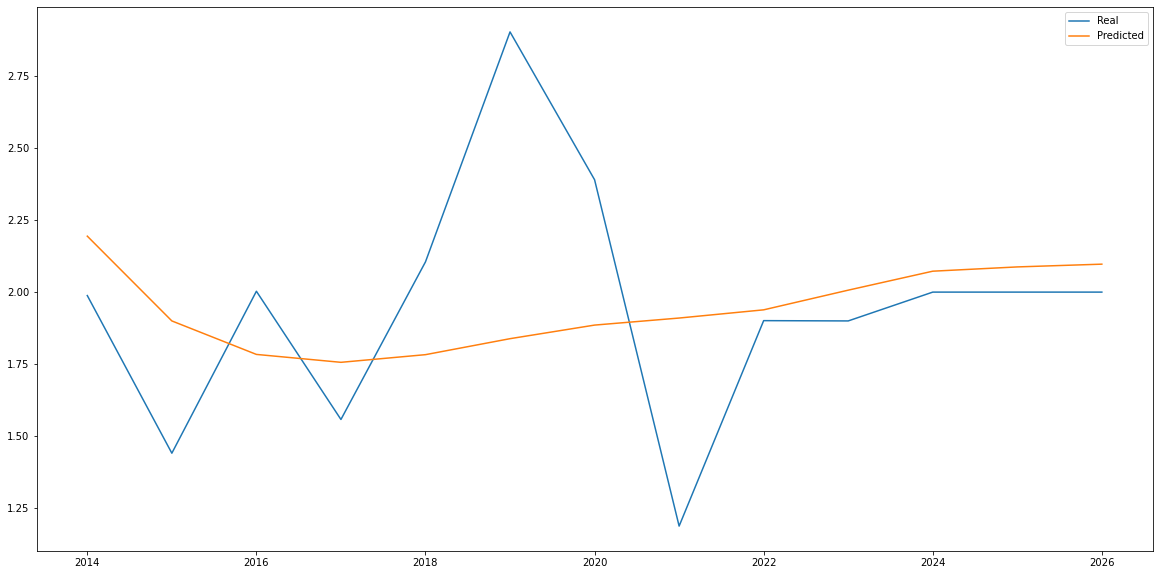

In [50]:
# Plot the real vs predicted prices as a line chart
Inflation.plot(figsize=(20,10))

In [51]:
from sklearn.metrics import r2_score

In [53]:
y_true = Inflation["Real"]
y_pred = Inflation["Predicted"]
r2_score(y_true, y_pred)

-0.11835378059241819